# Traditional Approach for Training with Visual BackProp

In this notebook, we apply the traditional approach of training a deep neural network model for predicting steering angle based on the input images.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2
import ntpath

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import warnings
warnings.filterwarnings("ignore")

In [2]:
import random

## Data Pre-Processing

In [3]:
data_path = 'data'
path = os.path.join(data_path,'driving_log.csv')
data = pd.read_csv(path)

In [4]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [5]:
center = data[data.columns[0]].values
left = data[data.columns[1]].values
right = data[data.columns[2]].values
steering = data[data.columns[3]].values

no_of_examples = len(steering)
print("Total Number of Samples :", no_of_examples)

Total Number of Samples : 8036


In [6]:
image_path = 'IMG'
image_path = os.path.join(data_path, image_path)

In [7]:
def random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

In [8]:
x = []
y = []

steer_adjust_factor = 0.2
IMAGE_HEIGHT = 100 
IMAGE_WIDTH = 100

for i in range(no_of_examples):
    for choice in range(3):
        if choice == 0: # Center Image
            img = cv2.imread(os.path.join(image_path, center[i]))
            steering_angle = steering[i]
        elif choice == 1: # Left Image
            img = cv2.imread(os.path.join(image_path, left[i]))
            steering_angle = steering[i] + steer_adjust_factor
        elif choice == 2: # Right Image
            img = cv2.imread(os.path.join(image_path, right[i]))
            steering_angle = steering[i] - steer_adjust_factor
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1]
        img = img[50:,:]
        img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        x.append(img)
        y.append(steering_angle)
        
        flipped_img, flipped_steering_angle = random_flip(img, steering_angle)
                
        x.append(flipped_img)
        y.append(flipped_steering_angle)

x = np.array(x)
x = np.reshape(x, [x.shape[0], x.shape[1], x.shape[2], 1])

y = np.array(y)
y = np.reshape(y, [y.shape[0],1])

print("x shape :", x.shape)
print("y shape :", y.shape)

x shape : (48216, 100, 100, 1)
y shape : (48216, 1)


In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train_size = x_train.shape[0]
x_test_size = x_test.shape[0]

print("x_train size :", x_train_size)
print("x_test size :", x_test_size)

x_train size : 38572
x_test size : 9644


In [10]:
def get_default_device():
  # Pick GPU, if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  # Move tensors to chosen device
  if isinstance(data, (list, tuple)):
    # If the instance is a list/tuple, transfer each element to chosen device
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  # non_blocking=True doesn't block the execution of the host device until transfers complete

class DeviceDataLoader():
  # Wrap a dataloader to move data to a device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    # Yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # Number of batches
    return len(self.dl)

In [11]:
# Get the default device
device = get_default_device()
device

device(type='cuda')

In [12]:
x_train_tensor = torch.Tensor(x_train).permute(0, 3, 1, 2)  # Change channels last to channels first
y_train_tensor = torch.Tensor(y_train)

x_test_tensor = torch.Tensor(x_test).permute(0, 3, 1, 2)  # Change channels last to channels first
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=3, pin_memory=True)

train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Model

In [13]:
class CNNModel(nn.Module):
    def __init__(self, height, width):
        super(CNNModel, self).__init__()
        
        self.height = height
        self.width = width
        
        # Input normalization
        self.norm = nn.BatchNorm2d(1)

        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * (height // 16) * (width // 16), 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)
        
        # Dropout and Batch normalization
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.norm(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.batchnorm1(self.fc1(x))
        x = self.batchnorm2(self.fc2(x))
        x = self.batchnorm3(self.fc3(x))
        x = self.fc4(x)
        return x

In [14]:
model = CNNModel(IMAGE_HEIGHT, IMAGE_WIDTH)

In [15]:
model =  model.to(device)
if device == 'cuda':
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

In [16]:
print(summary(model, input_size=(1, IMAGE_HEIGHT, IMAGE_WIDTH)))

Layer (type:depth-idx)                   Param #
├─BatchNorm2d: 1-1                       2
├─Sequential: 1-2                        --
|    └─Conv2d: 2-1                       320
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       9,248
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       18,496
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       36,928
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      73,856
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
|    └─Conv2d: 2-14                      147,584
|    └─ReLU: 2-15                        --
|    └─MaxPool2d: 2-16                   --
├─Linear: 1-3                            2,359,808
├─Linear: 1-4                            131,328
├─Linear: 1-5                          

In [17]:
lr = 0.0001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [18]:
class VisualBackpropWrapper():
    """
        Wraps the model and gives ability to extract importance masks
        for feature layers in convolutional networks.
        Implements idea from article: https://arxiv.org/pdf/1611.05418.pdf
        Wrapped model must have nn.Sequential fileld named "features" with all features layers
    """
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.initialize_modules()

    """
        Initializes self.modules and its params from net structure
    """
    def initialize_modules(self):
        self.modules = []
        for _, module in self.model.features._modules.items():
            transformation_params = None
            if 'Conv2d' in str(module):
                transformation_params = (module.kernel_size, module.stride, module.padding)
            if 'Pool' in str(module):
                transformation_params = ((module.kernel_size, module.kernel_size), \
                                        (module.stride, module.stride), \
                                        (module.padding, module.padding))
            self.modules.append((module, transformation_params))

    """
        Return relevancy masks for batch of images computed by VisualBackprop
    """
    def get_masks_for_batch(self, x_batch):
        all_outputs = []
        x_batch = x_batch.to(self.device)
        for module, transformation_params in self.modules:
            x_batch = module(x_batch)
            averaged_maps = torch.mean(x_batch, 1, True)
            flatten_maps = averaged_maps.view(averaged_maps.size(0), -1)
            maps_max = torch.max(flatten_maps, 1, True)[0].unsqueeze(2).unsqueeze(3)
            maps_min = torch.min(flatten_maps, 1, True)[0].unsqueeze(2).unsqueeze(3)
            averaged_maps = (averaged_maps - maps_min) / (maps_max - maps_min + 1e-6)
            if transformation_params:
                all_outputs.append((averaged_maps, transformation_params))

        last_result = None
        for maps, (kernel_size, stride, padding) in reversed(all_outputs):
            if last_result is None:
                last_result = maps
            else:
                if last_result.shape[2] > maps.shape[2]:
                    last_result = last_result[:, :, :maps.shape[2], :]
                elif last_result.shape[2] < maps.shape[2]:
                    maps = maps[:, :, :last_result.shape[2], :]
                
                if last_result.shape[3] > maps.shape[3]:
                    last_result = last_result[:, :, :, :maps.shape[3]]
                elif last_result.shape[3] < maps.shape[3]:
                    maps = maps[:, :, :, :last_result.shape[3]]
                last_result = last_result.mul(maps)
            last_result = F.conv_transpose2d(
                last_result, 
                torch.ones(1, 1, kernel_size[0], kernel_size[1], device=self.device), 
                stride=stride, 
                output_padding=(0, 0)
            )
        return F.relu(last_result)

In [19]:
# Training Helper Function to Format Time
def format_time(seconds):
  days = int(seconds / 3600/24)
  seconds = seconds - days*3600*24
  hours = int(seconds / 3600)
  seconds = seconds - hours*3600
  minutes = int(seconds / 60)
  seconds = seconds - minutes*60
  secondsf = int(seconds)
  seconds = seconds - secondsf
  millis = int(seconds*1000)

  f = ''
  i = 1
  if days > 0:
    f += str(days) + 'D'
    i += 1
  if hours > 0 and i <= 2:
    f += str(hours) + 'h'
    i += 1
  if minutes > 0 and i <= 2:
    f += str(minutes) + 'm'
    i += 1
  if secondsf > 0 and i <= 2:
    f += str(secondsf) + 's'
    i += 1
  if millis > 0 and i <= 2:
    f += str(millis) + 'ms'
    i += 1
  if f == '':
    f = '0ms'
  return f

In [20]:
def visualize_images_with_masks(images, masks, text, outputs, labels, figsize=(20, 20), columns=3):
    rows = (images.shape[0] + columns - 1) // columns
    
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    fig.suptitle(text, fontsize=14, fontweight='bold')
    fig.tight_layout(pad=5.0)
    
    masks_np = masks.detach().cpu().numpy()
    red_mask = np.zeros((masks_np.shape[0], masks_np.shape[2], masks_np.shape[3], 4))
    red_mask[:,:,:,0] = np.squeeze(masks_np, 1)
    red_mask[:,:,:,3] = red_mask[:,:,:,0]

    count = 0
    
    for i in range(rows):
        for j in range(columns):
            axs[i][j].imshow(images[count][0].cpu(), cmap='gray')
            axs[i][j].imshow(red_mask[count] / np.max(red_mask[count]))
            axs[i][j].get_xaxis().set_ticks([])
            axs[i][j].get_yaxis().set_ticks([])
            title = f"Predicted Steering: {outputs[count].item():.4f} | Actual Steering: {labels[count].item():.4f}"
            axs[i][j].set_title(title)
            count += 1

def train_with_logging(model, device, train_loader, optimizer, total_num_iterations, display_samples, display_labels, save_dir='./results/'):
    train_losses = []
    test_losses = []
    
    num_iterations = 0
    while(num_iterations < total_num_iterations):
        start_time = time.time()
        model.train()
        train_running_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item() * inputs.size(0)
            
        train_loss = train_running_loss / len(train_dataset)
        train_losses.append(train_loss)
    
        model.eval()
        test_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item() * inputs.size(0)

            test_loss = test_running_loss / len(test_dataset)
            test_losses.append(test_loss)

            outputs = model(display_samples)
            visual_backprop = VisualBackpropWrapper(model, device)
            display_masks = visual_backprop.get_masks_for_batch(display_samples)
            visualize_images_with_masks(display_samples, display_masks, f"Iteration {num_iterations+1}", outputs, display_labels)
            plt.savefig(os.path.join(save_dir, f"{num_iterations+1}.jpg"))
            plt.close()

        cur_time = time.time()
        epoch_time = cur_time - start_time

        print(f'Epoch [{num_iterations+1}/{total_num_iterations}] | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}')
        print(f'Time Taken : {format_time(epoch_time)}')
        print('')
        
        num_iterations += 1
    return train_losses, test_losses

In [21]:
test_batch = None
test_label = None

for x in test_loader:
    test_batch = x[0]
    test_label = x[1]
    random_integer = random.randint(0, len(test_loader))
    if random_integer <= len(test_loader) // 2:
        break

test_batch = test_batch[:9]
test_label = test_label[:9]

In [22]:
train_losses, test_losses = train_with_logging(model, device, train_loader, optimizer, 20, test_batch, test_label)

Epoch [1/20] | Train Loss: 0.0272 | Test Loss: 0.0106
Time Taken : 37s559ms

Epoch [2/20] | Train Loss: 0.0128 | Test Loss: 0.0104
Time Taken : 31s290ms

Epoch [3/20] | Train Loss: 0.0113 | Test Loss: 0.0103
Time Taken : 19s960ms

Epoch [4/20] | Train Loss: 0.0108 | Test Loss: 0.0102
Time Taken : 46s369ms

Epoch [5/20] | Train Loss: 0.0106 | Test Loss: 0.0093
Time Taken : 29s258ms

Epoch [6/20] | Train Loss: 0.0104 | Test Loss: 0.0105
Time Taken : 41s970ms

Epoch [7/20] | Train Loss: 0.0101 | Test Loss: 0.0091
Time Taken : 20s557ms

Epoch [8/20] | Train Loss: 0.0097 | Test Loss: 0.0089
Time Taken : 27s39ms

Epoch [9/20] | Train Loss: 0.0097 | Test Loss: 0.0088
Time Taken : 33s798ms

Epoch [10/20] | Train Loss: 0.0094 | Test Loss: 0.0085
Time Taken : 19s972ms

Epoch [11/20] | Train Loss: 0.0092 | Test Loss: 0.0089
Time Taken : 20s51ms

Epoch [12/20] | Train Loss: 0.0090 | Test Loss: 0.0087
Time Taken : 42s312ms

Epoch [13/20] | Train Loss: 0.0087 | Test Loss: 0.0084
Time Taken : 34s127m

Text(0.5, 1.0, 'Loss vs. No. of epochs')

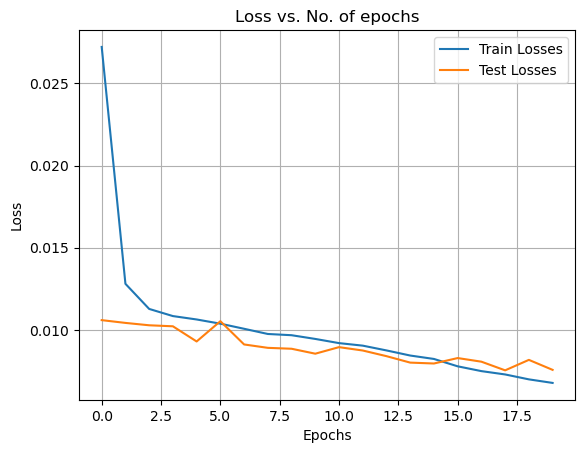

In [23]:
plt.plot(train_losses, label='Train Losses')
plt.plot(test_losses, label='Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [25]:
# Saving model state
state = {
        'model': model.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses,
    }

torch.save(state, 'traditional_approach_visual.pth')